## Imports and definitions

In [2]:
import ot
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ot
from utils.image import Image
from utils.Visualizations import *
from utils.utils import *
import itertools
import glob
import time
from tqdm import tqdm

In [50]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)

In [51]:
resolutions = [32, 64, 128, 256, 512]
image_numbers = ['01','02','03','04','05','06','07','08','09','10']

In [52]:
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = [path for path in glob.glob(categories_pattern) if os.path.isdir(path)]
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]
for category in category_names:
    print(category)

CauchyDensity
ClassicImages
GRFmoderate
GRFrough
GRFsmooth
LogGRF
LogitGRF
MicroscopyImages
Shapes
WhiteNoise


# Reading images

## Single Image

In [5]:
image_1_index = 0
image_2_index = 1
resolution = 32
noise_param = 1e-2
SNR = 1

In [6]:
image1 = Image(resolution, category_names[0], image_1_index, full_path)
image2 = Image(resolution, category_names[0], image_2_index, full_path)
cost_matrix = calculate_costs(image1.image.shape)


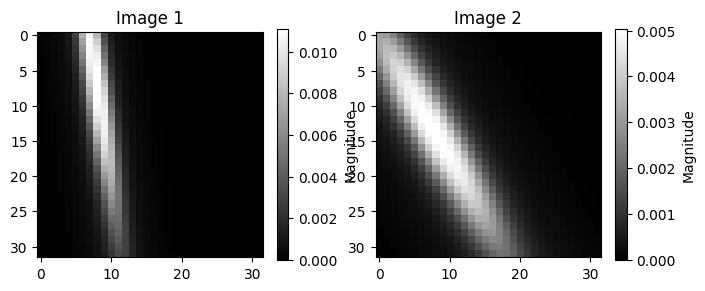

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
create_subplot(axs[0], image1.image, "Image 1")
create_subplot(axs[1], image2.image, "Image 2")

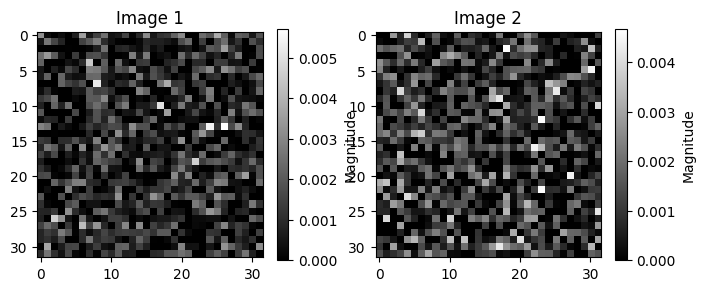

In [8]:
results = Image.analyze_image_pair(image1, image2, cost_matrix, 1, noise_param)
#plot:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
create_subplot(axs[0], image1.image_post, "Image 1")
create_subplot(axs[1], image2.image_post, "Image 2")

In [62]:
w1_dist_original = calculate_and_time_wasserstein(image1.image, image2.image, cost_matrix)[0]
w1_dist_noised = calculate_and_time_wasserstein(image1.image_post, image2.image_post, cost_matrix)[0]
print(f'The Wasserstein distance between the two original images is {w1_dist_original}, and between the two noised images is {w1_dist_noised}')

f_dist_original = calculate_and_time_fourier1(image1.image, image2.image)[0]
f_dist_noised = calculate_and_time_fourier1(image1.image_post, image2.image_post)[0]
print(f'The Fourier distance between the two original images is {f_dist_original}, and between the two noised images is {f_dist_noised}')

l2_dist_original = calculate_and_time_l2(image1.image, image2.image)[0]
image1.image_noised /= image1.image_noised.sum()
image2.image_noised /= image2.image_noised.sum()
l2_dist_noised = calculate_and_time_l2(image1.image_noised, image2.image_noised)[0]
print(f'The L2 distance between the two original images is {l2_dist_original}, and between the two noised images is {l2_dist_noised}')


The Wasserstein distance between the two original images is 3.85597850768735, and between the two noised images is 1.3451982811835927
The Fourier distance between the two original images is 2.3234400541511646, and between the two noised images is 0.6183362725999519
The L2 distance between the two original images is 0.06404417932594936, and between the two noised images is 0.45436326686480805


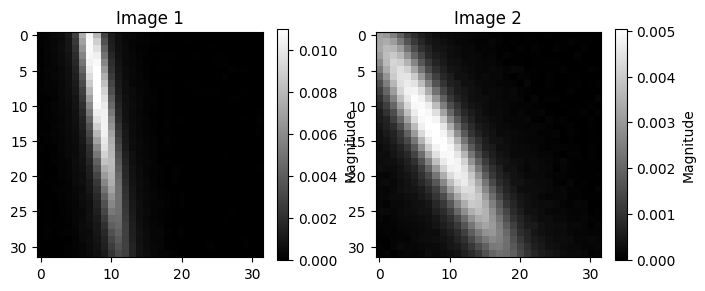

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
create_subplot(axs[0], image1.image_post, "Image 1")
create_subplot(axs[1], image2.image_post, "Image 2")

## Scaling up, looking into all pairs of images in a single class

In [5]:
df_im_l1 = pd.DataFrame()
category = category_names[0]
res = 32
num_samples = 5
category_dir = os.path.join(full_path, category)
SNR_values = np.logspace(start=5, stop=1, num=31)
noise_values = np.logspace(start=-5, stop=-1, num=31)
pairs = list(itertools.combinations(image_numbers, 2))
cost_matrix = calculate_costs((res, res))
df_im_l1 = pd.DataFrame()

### Create the data from scratch - single class

In [ ]:
for SNR in tqdm(SNR_values):
    noise_param = noise_from_SNR(SNR, 1, res)
    for image_pair in pairs:
        image1 = Image(res, category, image_pair[0], full_path)
        image2 = Image(res, category, image_pair[1], full_path)

        # Calculate original distances without noise
        w1_dist_original, w1_time_original = calculate_and_time_wasserstein(image1.image, image2.image, cost_matrix)
        f_dist_original, f_time_original = calculate_and_time_fourier1(image1.image, image2.image)
        l2_dist_original, l2_time_original = calculate_and_time_l2(image1.image, image2.image)

        results = Image.analyze_image_pair(image1, image2, cost_matrix, num_samples, noise_param)
        w1_dist_noised, f_dist_noised, l2_dist_noised, time_w1, time_f, time_l2 = results

        new_row = {
            'Category': category,
            'image1_index': image_pair[0],
            'image2_index': image_pair[1],
            'Noise': noise_param,
            'SNR': SNR,
            'Resolution': res,
            'Wasserstein Original': w1_dist_original,
            'Wasserstein Noised': w1_dist_noised,
            'Wasserstein Ratio': w1_dist_original / w1_dist_noised,
            'Wasserstein Time': time_w1,
            'Fourier Original': f_dist_original, 
            'Fourier Noised': f_dist_noised,
            'Fourier Ratio': f_dist_original / f_dist_noised,
            'Fourier Time': time_f, 
            'L2 Original': l2_dist_original,
            'L2 Noised': l2_dist_noised,
            'L2 Ratio': l2_dist_original / l2_dist_noised,
            'L2 Time': time_l2}  
        
        df_im_l1 = df_im_l1._append(new_row, ignore_index=True)
df_im_l1.to_csv('results.csv', index=False)


### Read The data

In [16]:
df_im_l1 = pd.read_csv('csvs/L2_F_noised_W1_post_2_4_2024.csv')

### Plot

In [13]:
subset = df_im_l1.drop(['Category','image1_index', 'image2_index'], axis=1)
df_grouped = subset.groupby('SNR').mean().reset_index()
df_grouped.head()

,SNR,Noise,Resolution,Wasserstein Original,Wasserstein Noised,Wasserstein Ratio,Wasserstein Time,Fourier Original,Fourier Noised,Fourier Ratio,Fourier Time,L2 Original,L2 Noised,L2 Ratio,L2 Time
0,10.000000,0.100000,32.0,3.8175,1.380165,2.768076,0.067839,1.543288,127.105555,0.031281,0.001990,0.032312,10.989478,0.007574,0.000015
1,13.593564,0.073564,32.0,3.8175,1.380841,2.774873,0.068013,1.543288,193.475712,0.031643,0.001998,0.032312,16.599311,0.007484,0.000015
2,18.478498,0.054117,32.0,3.8175,1.386693,2.760545,0.067483,1.543288,2447.124466,0.032587,0.001941,0.032312,215.607572,0.007971,0.000024
3,25.118864,0.039811,32.0,3.8175,1.389757,2.746405,0.068022,1.543288,246.104064,0.036459,0.001992,0.032312,20.771204,0.008527,0.000026
4,34.145489,0.029286,32.0,3.8175,1.392589,2.732977,0.067997,1.543288,75.674810,0.046486,0.002025,0.032312,6.495863,0.011345,0.000021


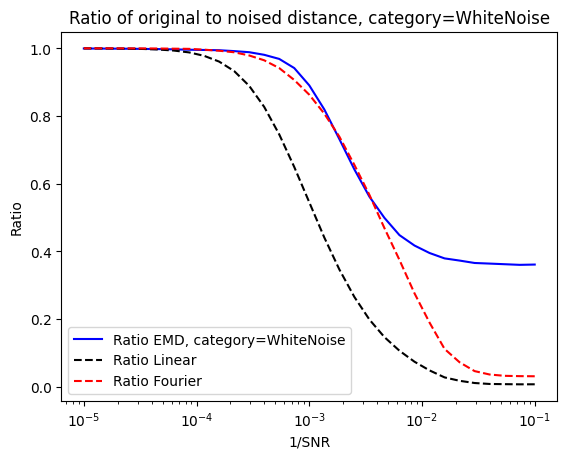

In [14]:
plt.plot(1/df_grouped['SNR'], 1 / df_grouped['Wasserstein Ratio'], label=f'Ratio EMD, category={category}', color='blue')
plt.plot(1/df_grouped['SNR'], df_grouped['L2 Ratio'], label='Ratio Linear', color='black', linestyle='--')
plt.plot(1/df_grouped['SNR'], df_grouped['Fourier Ratio'], label='Ratio Fourier', color='red', linestyle='--')

plt.xscale('log')
plt.title(f'Ratio of original to noised distance, category={category}')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.show()

## Scaling up, looking into all classes

#### Re-create data

In [10]:
df_im_l1 = pd.DataFrame()
for category in category_names:
    for noise_param in tqdm(noise_values):
        SNR = 1 / noise_param
        for image_pair in pairs:
            image1 = Image(res, category, image_pair[0], full_path)
            image2 = Image(res, category, image_pair[1], full_path)

            # Calculate original distances without noise
            w1_dist_original, w1_time_original = calculate_and_time_wasserstein(image1.image, image2.image, cost_matrix)
            f_dist_original, f_time_original = calculate_and_time_fourier1(image1.image, image2.image)
            l2_dist_original, l2_time_original = calculate_and_time_l2(image1.image, image2.image)

            results = Image.analyze_image_pair(image1, image2, cost_matrix, num_samples, noise_param)
            w1_dist_noised, f_dist_noised, l2_dist_noised, time_w1, time_f, time_l2 = results

            new_row = {
                'Category': category,
                'image1_index': image_pair[0],
                'image2_index': image_pair[1],
                'Noise': noise_param,
                'SNR': SNR,
                'Resolution': res,
                'Wasserstein Original': w1_dist_original,
                'Wasserstein Noised': w1_dist_noised,
                'Wasserstein Ratio': w1_dist_original / w1_dist_noised,
                'Wasserstein Time': time_w1,
                'Fourier Original': f_dist_original, 
                'Fourier Noised': f_dist_noised,
                'Fourier Ratio': f_dist_original / f_dist_noised,
                'Fourier Time': time_f, 
                'L2 Original': l2_dist_original,
                'L2 Noised': l2_dist_noised,
                'L2 Ratio': l2_dist_original / l2_dist_noised,
                'L2 Time': time_l2}  

            df_im_l1 = df_im_l1._append(new_row, ignore_index=True)
df_im_l1.to_csv('results.csv', index=False)


100%|██████████| 31/31 [19:58<00:00, 38.67s/it]


#### Read data

In [3]:
#Just reading the csv file:
df_im_l1 = pd.read_csv('csvs/L2_F_noised_W1_post_2_4_2024.csv')

#### Results

In [48]:
category_index = 1
subset = df_im_l1[df_im_l1['Category'] == category_names[category_index]]
subset = df_im_l1.drop(['Category','image1_index', 'image2_index'], axis=1)
df_grouped = subset.groupby('Noise').mean().reset_index()

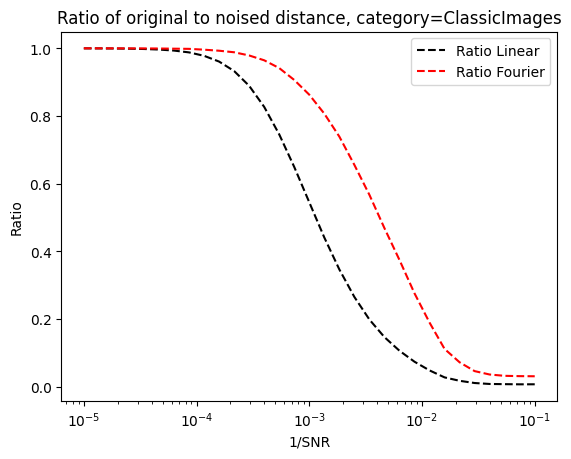

In [50]:
plt.plot(1/df_grouped['SNR'], 1 / df_grouped['Wasserstein Ratio'], label=f'Ratio EMD, category={category}', color='blue')
plt.plot(1/df_grouped['SNR'], df_grouped['L2 Ratio'], label='Ratio Linear', color='black', linestyle='--')
plt.plot(1/df_grouped['SNR'], df_grouped['Fourier Ratio'], label='Ratio Fourier', color='red', linestyle='--')

plt.xscale('log')
plt.title(f'Ratio of original to noised distance, category={category_names[category_index]}')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.show()

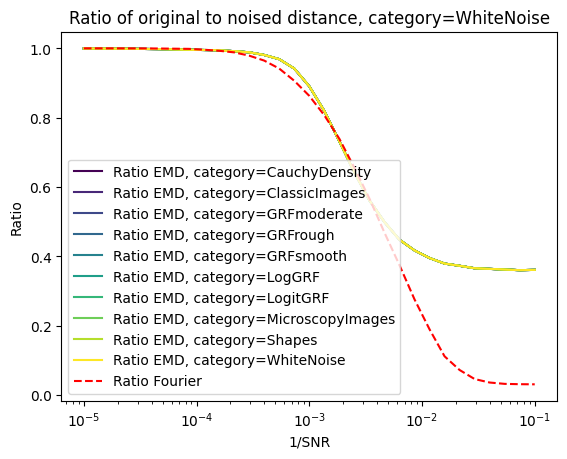

In [21]:
colors = plt.cm.viridis(np.linspace(0, 1, 10))
for category in category_names:
    category_index = category_names.index(category)
    subset = df_im_l1[df_im_l1['Category'] == category]
    subset = df_im_l1.drop(['Category','image1_index', 'image2_index'], axis=1)
    df_grouped = subset.groupby('Noise').mean().reset_index()

    plt.plot(1/df_grouped['SNR'], 1 / df_grouped['Wasserstein Ratio'], label=f'Ratio EMD, category={category}', color=colors[category_index])
plt.plot(1/df_grouped['SNR'], df_grouped['Fourier Ratio'], label='Ratio Fourier', color='red', linestyle='--')

plt.xscale('log')
plt.title(f'Ratio of original to noised distance, category={category}')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.show()

## Looking into different resolutions

In [39]:
df1 = pd.read_csv('results.csv')
df2 = pd.read_csv('csvs/diff_res.csv')

In [40]:
SNR_values1 = df1['SNR'].unique()
SNR_values2 = df2['SNR'].unique()

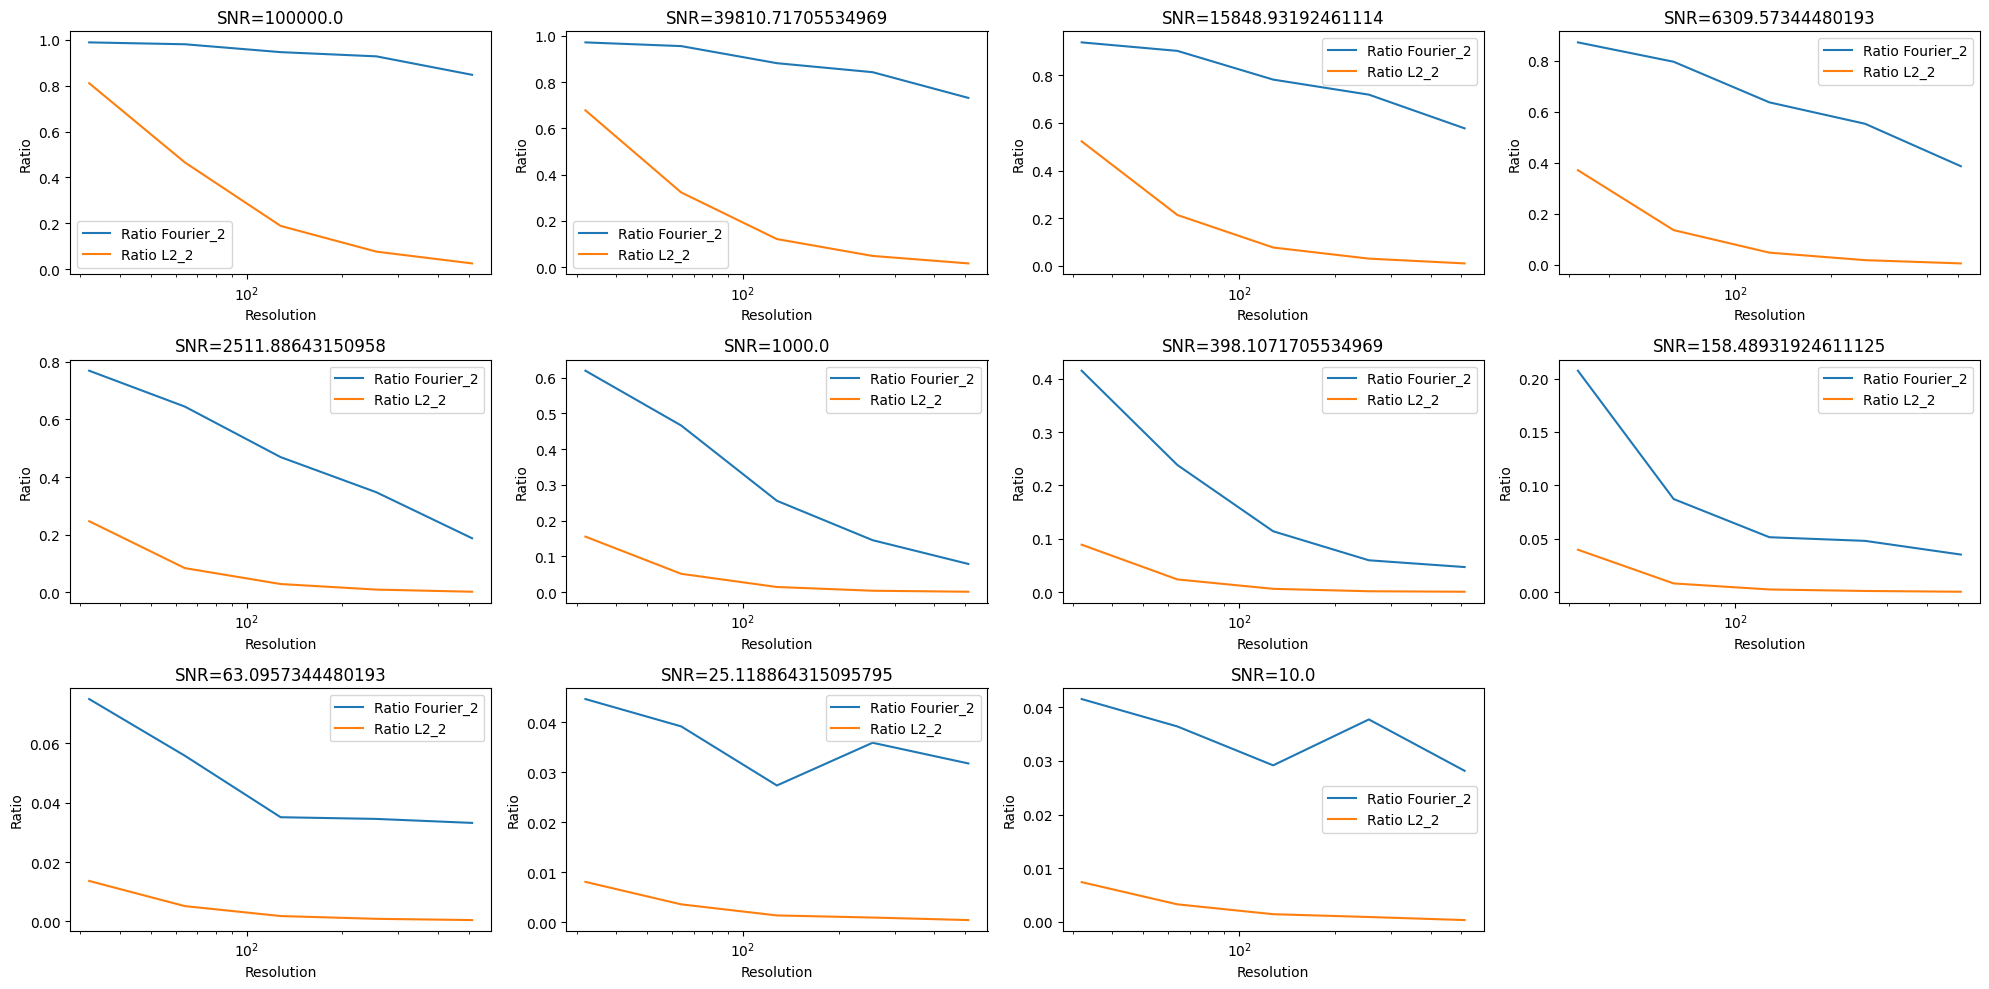

In [41]:
subset1 = df1.drop(['Category','image1_index', 'image2_index'], axis=1)
subset2 = df2.drop(['Category','image1_index', 'image2_index'], axis=1)

fig = plt.figure(figsize=(20, 10))
# Plot the ratio of the original to the noised distance for each SNR value
for i, SNR in enumerate(SNR_values):
    plt.subplot(3, 4, i+1)
    subset_SNR1 = subset1[subset1['SNR'] == SNR]
    subset_SNR2 = subset2[subset2['SNR'] == SNR]
    df_grouped1 = subset_SNR1.groupby('Resolution').mean().reset_index()
    df_grouped2 = subset_SNR2.groupby('Resolution').mean().reset_index()

    #plt.plot(df_grouped1['Resolution'], df_grouped1['Fourier Ratio'], label='Ratio Fourier_1', linestyle='--')
    #plt.plot(df_grouped1['Resolution'], df_grouped1['L2 Ratio'], label='Ratio L2_1', linestyle='--')
    plt.plot(df_grouped2['Resolution'], df_grouped2['Fourier Ratio'], label='Ratio Fourier_2')
    plt.plot(df_grouped2['Resolution'], df_grouped2['L2 Ratio'], label='Ratio L2_2')
    plt.title(f'SNR={SNR}')
    plt.xscale('log')
    plt.xlabel('Resolution')
    plt.ylabel('Ratio')
    plt.legend()

plt.tight_layout()
plt.show()

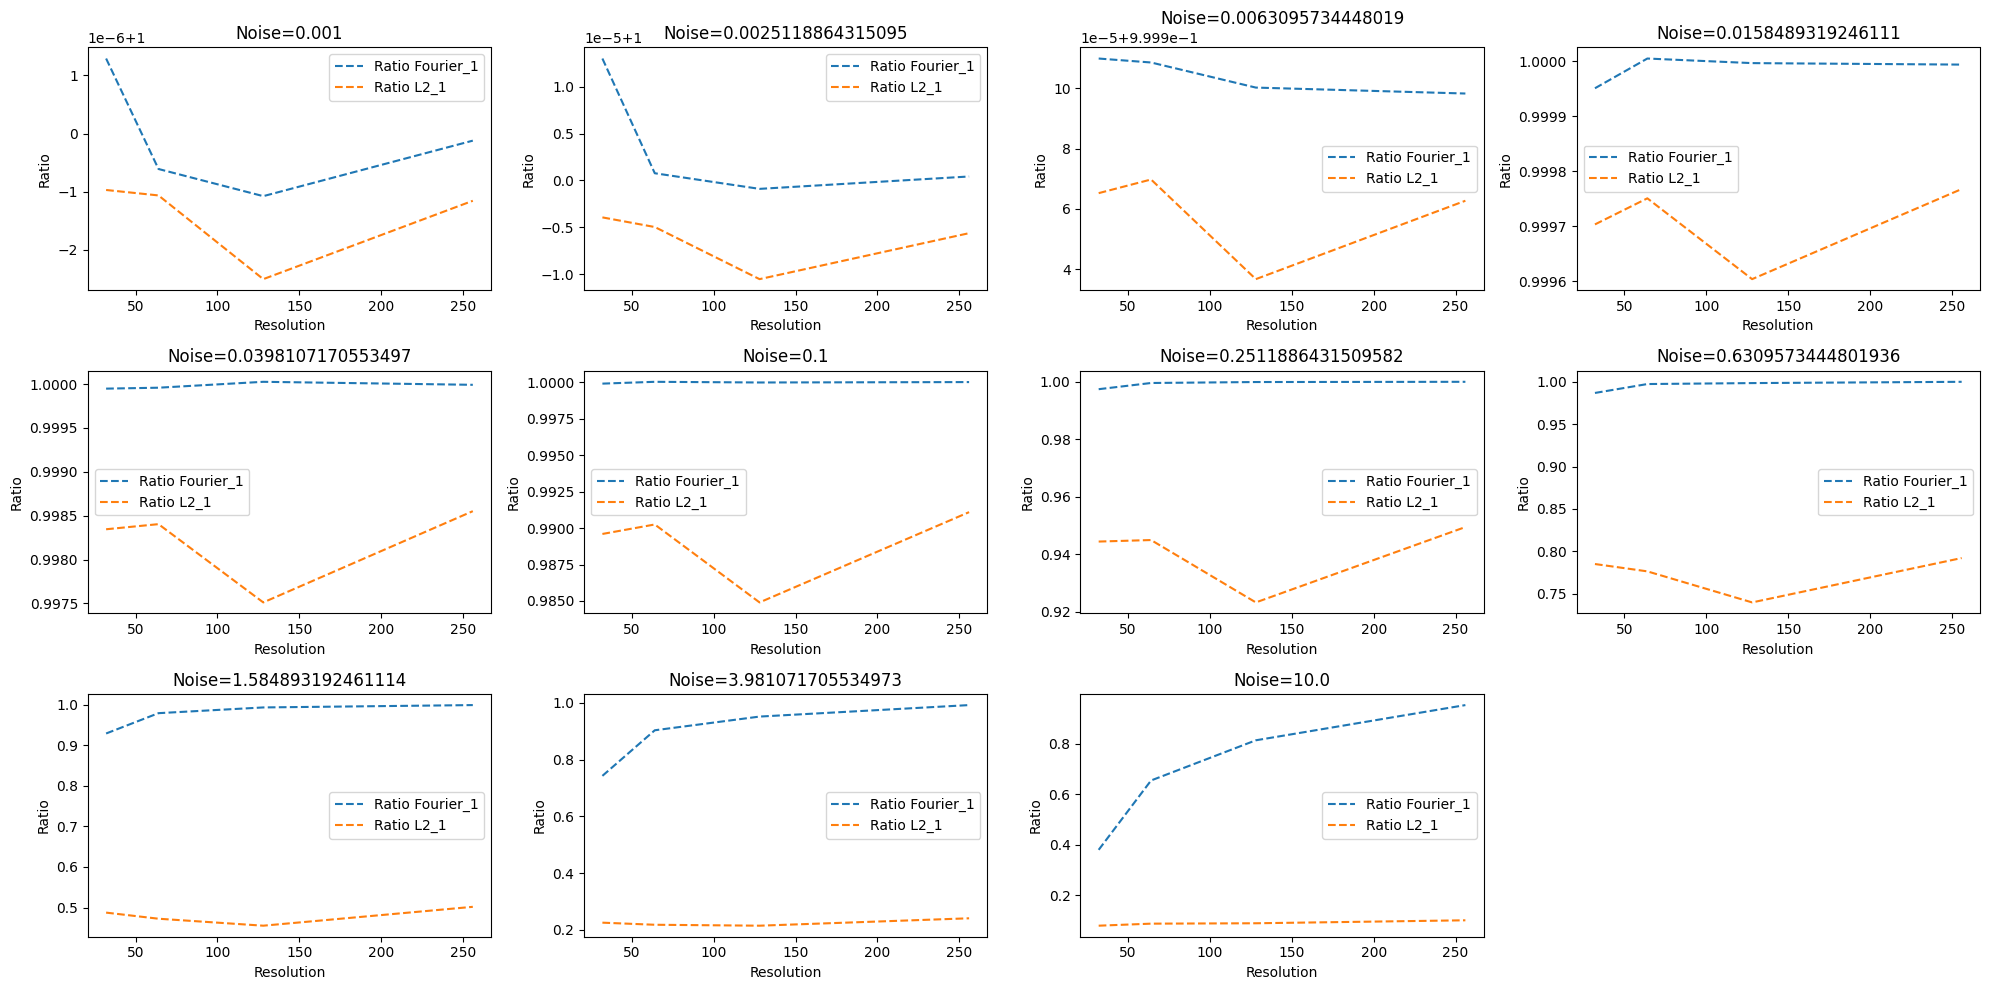

In [137]:
df1 = pd.read_csv('results2.csv')
subset1 = df1.drop(['Category','image1_index', 'image2_index'], axis=1)
noise_values = df1['Noise'].unique()


fig = plt.figure(figsize=(20, 10))
# Plot the ratio of the original to the noised distance for each SNR value
for i, noise_param in enumerate(noise_values):
    plt.subplot(3, 4, i+1)
    subset_SNR1 = subset1[subset1['Noise'] == noise_param]
    df_grouped1 = subset_SNR1.groupby('Resolution').mean().reset_index()

    plt.plot(df_grouped1['Resolution'], df_grouped1['Fourier Ratio'], label='Ratio Fourier_1', linestyle='--')
    plt.plot(df_grouped1['Resolution'], df_grouped1['L2 Ratio'], label='Ratio L2_1', linestyle='--')
    plt.title(f'Noise={noise_param}')
    #plt.xscale('log')
    plt.xlabel('Resolution')
    plt.ylabel('Ratio')
    plt.legend()

plt.tight_layout()
plt.show()

In [138]:
subset = df1.drop(['Category','image1_index', 'image2_index'], axis=1)
category = category_names[0]
print(f'The lowest L2 ratio is {df1[df1["Category"] == category]["L2 Ratio"].min()}')
print(f'The lowest Fourier ratio is {df1[df1["Category"] == category]["Fourier Ratio"].min()}')

The lowest L2 ratio is 0.0229628897088448
The lowest Fourier ratio is 0.1196147274592348


In [139]:
noises = subset['Noise'].unique()

In [168]:
subset2 = subset[subset['Noise'] == noises[7]]

In [169]:
subset2['Noise'].unique()

array([0.63095734])

In [170]:
df_grouped = subset2.groupby('Resolution').mean().reset_index()
len(subset2.index)

180

In [171]:
df_grouped.head()

,Resolution,Noise,SNR,Fourier Original,Fourier Noised,Fourier Ratio,Fourier Time,L2 Original,L2 Noised,L2 Ratio,L2 Time
0,32,0.630957,1622.930629,2.772512,2.795681,0.986832,0.001268,0.042054,0.051458,0.785023,0.000001
1,64,0.630957,6491.722516,10.886676,10.907496,0.997341,0.004678,0.019989,0.024815,0.776363,0.000003
2,128,0.630957,25966.890065,41.637772,41.671112,0.998473,0.019239,0.009938,0.012535,0.739732,0.000008
3,256,0.630957,103867.560261,198.258018,198.253568,0.999979,0.114378,0.005592,0.006735,0.792081,0.000163


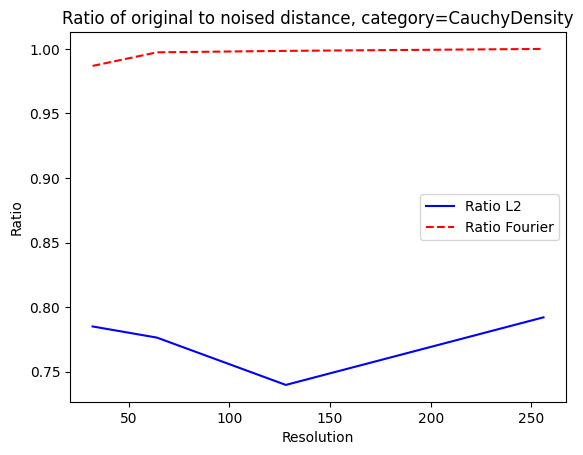

In [172]:
#df_grouped = subset.groupby('Noise').mean().reset_index()
df_grouped = subset2.groupby('Resolution').mean().reset_index()

plt.plot(df_grouped['Resolution'], df_grouped['L2 Ratio'], label='Ratio L2', color='blue')
plt.plot(df_grouped['Resolution'], df_grouped['Fourier Ratio'], label='Ratio Fourier', color='red', linestyle='--')

#plt.xscale('log')
plt.title(f'Ratio of original to noised distance, category={category}')
plt.xlabel('Resolution')
plt.ylabel('Ratio')
plt.legend()

plt.show()

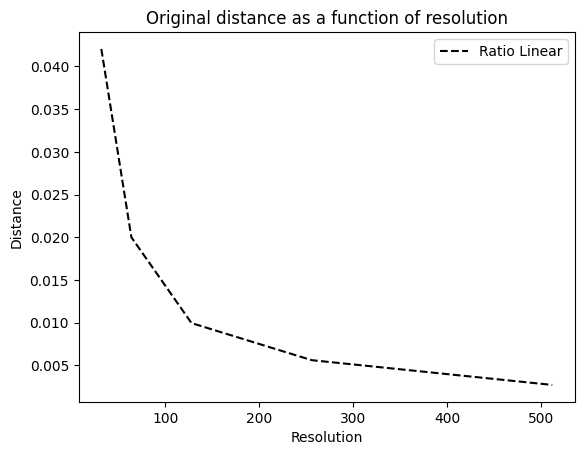

In [35]:
#plt.plot(df_grouped['Resolution'], df_grouped['Fourier Original'], label='Ratio Fourier', color='blue')
plt.plot(df_grouped['Resolution'], df_grouped['L2 Original'], label='Ratio Linear', color='black', linestyle='--')

plt.title('Original distance as a function of resolution')
plt.xlabel('Resolution')
plt.ylabel('Distance')
plt.legend()

plt.show()